# Análisis de Redes Sociales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import json
import os
import re
import nltk
from nltk.corpus import stopwords
import string
from unidecode import unidecode
from wordcloud import WordCloud
from collections import Counter

In [2]:
# nltk.download('stopwords')

## 2. Carga de Archivos

In [3]:
def load_tweets(file_path):
    tweets = []
    with open(file_path, 'r', encoding='utf-16') as file:
        for line in file:
            line = line.strip()
            try:
                tweets.append(json.loads(line))
            except:
                pass
    return pd.DataFrame(tweets)

## 3. Limpieza y Preprocesamiento de Datos

In [4]:
def parse_nested_json(x):
    if isinstance(x, str):
        try:
            return json.loads(x.replace("'", '"'))
        except json.JSONDecodeError:
            return None
    else:
        return x

In [5]:
stop_words = set(stopwords.words('spanish'))

Definimos el preprocesamiento de texto

In [6]:
def preprocess_text(text):
    # Convertir el texto a minúsculas
    text = text.lower()

    # Quitar URLs
    text = re.sub(r'http\S+', '', text)

    # Quitar caracteres especiales como `#`, `@` y apóstrofes
    text = re.sub(r'[@#\'’]', '', text)

    # Quitar números
    text = re.sub(r'\d+', '', text)

    # Quitar signos de puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Normalizar caracteres acentuados
    text = unidecode(text)

    # Quitar stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

Definimos el flujo de procesamiento de los archivos

In [7]:
def process_file(file_path):
    df = load_tweets(file_path)

    # Convert the data in the columns from JSON strings to dictionaries
    nested_columns = ['user', 'retweetedTweet', 'quotedTweet', 'mentionedUsers', 'inReplyToUser', 'media']
    for column in nested_columns:
        if column in df.columns:
            df[column] = df[column].apply(parse_nested_json)
            
    # Normalize the username
    df['user'] = df['user'].apply(lambda x: x['username'].lower())

    # Convert the date column to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Preprocess text
    df['processed_text'] = df['rawContent'].apply(preprocess_text)

    # Extract mentioned users and normalize them
    df['mentioned_users'] = df['mentionedUsers'].apply(lambda users: [user['username'].lower() for user in users])

    # Find the usernames that are mentioned in the text
    df['replied_to'] = df['inReplyToUser'].apply(lambda x: x['username'].lower() if pd.notnull(x) else None)
    
    # Check if the tweet is a retweet
    df['quoted'] = df['quotedTweet'].apply(lambda x: x['user']['username'].lower() if pd.notnull(x) else None)

    df = df.copy()  # Avoid SettingWithCopyWarning

    return df

In [8]:
df_trafico = process_file('data/traficogt.txt')

In [9]:
df_trafico.head()

,id,id_str,url,date,user,lang,rawContent,replyCount,retweetCount,likeCount,...,source,sourceUrl,sourceLabel,media,card,_type,processed_text,mentioned_users,replied_to,quoted
0,1834236045598056867,1834236045598056867,https://x.com/traficogt/status/183423604559805...,2024-09-12 14:22:06+00:00,traficogt,es,Es comprensible la resolución... El ruso sabe ...,0,0,1,...,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet,comprensible resolucion ruso sabe engrasar maq...,[],None,monymmorales
1,1834029142565658846,1834029142565658846,https://x.com/monymmorales/status/183402914256...,2024-09-12 00:39:56+00:00,monymmorales,es,La corrupción de la @CC_Guatemala\nes descarad...,0,56,84,...,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",{'title': 'La Corte de Constitucionalidad orde...,snscrape.modules.twitter.Tweet,corrupcion ccguatemala descarada falsificacion...,[cc_guatemala],None,None
2,1834039491826180424,1834039491826180424,https://x.com/animaldgalaccia/status/183403949...,2024-09-12 01:21:04+00:00,animaldgalaccia,qme,@PNCdeGuatemala @mingobguate @FJimenezmingob @...,0,0,1,...,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet,pncdeguatemala mingobguate fjimenezmingob dieg...,"[pncdeguatemala, mingobguate, fjimenezmingob, ...",pncdeguatemala,None
3,1833963729136091179,1833963729136091179,https://x.com/EstacionDobleA/status/1833963729...,2024-09-11 20:20:01+00:00,estaciondoblea,qam,@amilcarmontejo @AztecaNoticiaGT @BancadaSemil...,0,0,0,...,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet,amilcarmontejo aztecanoticiagt bancadasemilla ...,"[amilcarmontejo, aztecanoticiagt, bancadasemil...",estaciondoblea,None
4,1833665391698092330,1833665391698092330,https://x.com/CubReserva/status/18336653916980...,2024-09-11 00:34:31+00:00,cubreserva,es,@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEM...,0,0,1,...,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet,aztecanoticiagt conapgt denunciaempagua munigu...,"[soy_502, aztecanoticiagt, conapgt, denunciaem...",cubreserva,None


In [10]:
df_arevalo = process_file('data/tioberny.txt')

In [11]:
df_arevalo.head()

,id,id_str,url,date,user,lang,rawContent,replyCount,retweetCount,likeCount,...,source,sourceUrl,sourceLabel,media,card,_type,processed_text,mentioned_users,replied_to,quoted
0,1834281080029110288,1834281080029110288,https://x.com/La_ReVoluZzion/status/1834281080...,2024-09-12 17:21:03+00:00,la_revoluzzion,es,"_\nConfirmado Compañeres,\n\nEl impuesto por l...",0,0,0,...,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet,confirmado companeres impuesto usembassyguate ...,"[usembassyguate, 48cantonestoto, usaidguate, u...",None,xelanewsgt
1,1834252464092069901,1834252464092069901,https://x.com/XelaNewsGt/status/18342524640920...,2024-09-12 15:27:20+00:00,xelanewsgt,es,#URGENTE Lo que los medios #faferos no informa...,12,80,142,...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,"{'photos': [], 'videos': [{'thumbnailUrl': 'ht...",None,snscrape.modules.twitter.Tweet,urgente medios faferos informaron ayer acerca ...,[],None,None
2,1834280919336976681,1834280919336976681,https://x.com/M24095273/status/183428091933697...,2024-09-12 17:20:25+00:00,m24095273,es,@IvanDuque @BArevalodeLeon Con que usaste PEGA...,0,0,0,...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet,ivanduque barevalodeleon usaste pegasus espiar...,"[ivanduque, barevalodeleon]",ivanduque,None
3,1834280512933732694,1834280512933732694,https://x.com/carlosalbesc/status/183428051293...,2024-09-12 17:18:48+00:00,carlosalbesc,es,@IvanDuque @BArevalodeLeon Entre Ellos se enti...,0,0,0,...,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet,ivanduque barevalodeleon entienden bien si est...,"[ivanduque, barevalodeleon]",ivanduque,None
4,1834279986254987428,1834279986254987428,https://x.com/Brenda_AGN/status/18342799862549...,2024-09-12 17:16:42+00:00,brenda_agn,es,El presidente @BArevalodeLeon y la vicepreside...,0,0,0,...,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,{'photos': [{'url': 'https://pbs.twimg.com/med...,None,snscrape.modules.twitter.Tweet,presidente barevalodeleon vicepresidenta karin...,"[barevalodeleon, karinherreravp, agn_noticias,...",None,None


Extraemos un grafo de interacciones

In [12]:
def extract_interactions(df):
    edges = []
    for _, row in df.iterrows():
        if row['mentioned_users']:
            for mentioned in row['mentioned_users']:
                edges.append((row['user'], mentioned, 'mention'))
        if row['replied_to']:
            edges.append((row['user'], row['replied_to'], 'reply'))
        if row['quoted']:
            edges.append((row['user'], row['quoted'], 'retweet'))

    edges_df = pd.DataFrame(edges, columns=['source', 'target', 'type'])
    G = nx.from_pandas_edgelist(edges_df, source='source', target='target', edge_attr='type', create_using=nx.DiGraph())
    return G

In [13]:
G_trafico = extract_interactions(df_trafico)

In [14]:
G_arevalo = extract_interactions(df_arevalo)

In [15]:
print(f"El grafo de tráfico tiene {G_trafico.number_of_nodes()} nodos y {G_trafico.number_of_edges()} aristas")

El grafo de tráfico tiene 2744 nodos y 7569 aristas


In [16]:
print(f"El grafo de Arevalo tiene {G_arevalo.number_of_nodes()} nodos y {G_arevalo.number_of_edges()} aristas")

El grafo de Arevalo tiene 3134 nodos y 12524 aristas


## 4. Análisis Exploratorio

In [17]:
def analyze_tweet_interactions(df):
    interactions = {
        'total_tweets': len(df),
        'replies': df['replied_to'].notnull().sum(),
        'retweets': df['quoted'].notnull().sum(),
        'mentions': df['mentioned_users'].apply(lambda x: len(x) > 0).sum()
    }
    return interactions

In [18]:
def get_frequent_hashtags(df):
    hashtags = df['hashtags'].explode().dropna()
    return Counter(hashtags).most_common(10)

In [19]:
def get_word_cloud(df, column):
    text = df[column].str.cat(sep='')
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [20]:
inter_arevalo = analyze_tweet_interactions(df_arevalo)
inter_trafico = analyze_tweet_interactions(df_trafico)

In [21]:
unq_users_arevalo = df_arevalo['user'].nunique()
unq_users_traffic = df_trafico['user'].nunique()

In [22]:
common_hashtags_arevalo = get_frequent_hashtags(df_arevalo)
common_hashtags_trafico = get_frequent_hashtags(df_trafico)

In [23]:
print("Bernardo Arévalo:")
print("\tInteracciones: ", inter_arevalo)
print("\tNúmero de tweets: ", len(df_arevalo))
print("\tUsuarios únicos: ", unq_users_arevalo)
print("\tHashtags más frecuentes: ", common_hashtags_arevalo)
print("\nTraficoGT:")
print("\tInteracciones:", inter_trafico)
print("\tNúmero de tweets: ", len(df_trafico))
print("\tUsuarios únicos: ", unq_users_traffic)
print("\tHashtags más frecuentes: ", common_hashtags_trafico)

Bernardo Arévalo:
	Interacciones:  {'total_tweets': 5019, 'replies': 4370, 'retweets': 295, 'mentions': 4836}
	Número de tweets:  5019
	Usuarios únicos:  2620
	Hashtags más frecuentes:  [('URGENTE', 26), ('GuatemalaSaleAdelante', 25), ('MinfinSaleAdelante', 17), ('Guatemala', 15), ('Presupuesto2025', 14), ('UnPresupuestoParaLaPoblación', 13), ('EnElPaísDCA', 12), ('NacionalesAGN', 8), ('XelaNews', 7), ('ElEstor', 7)]

TraficoGT:
	Interacciones: {'total_tweets': 5604, 'replies': 4150, 'retweets': 611, 'mentions': 4487}
	Número de tweets:  5604
	Usuarios únicos:  2071
	Hashtags más frecuentes:  [('AhoraLH', 18), ('AHORA', 18), ('Guatemala', 16), ('RenuncienGolpistas', 13), ('URGENTE', 10), ('guatemala', 9), ('ParoNacionalIndefinido', 9), ('Ahora', 8), ('LaHoraDeActualizarnos', 8), ('GuateResiste', 8)]


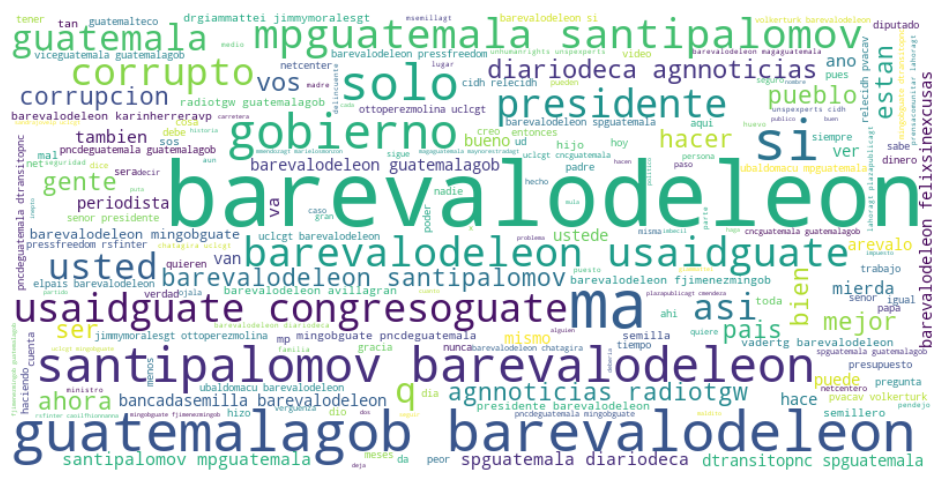

In [24]:
get_word_cloud(df_arevalo, 'processed_text')

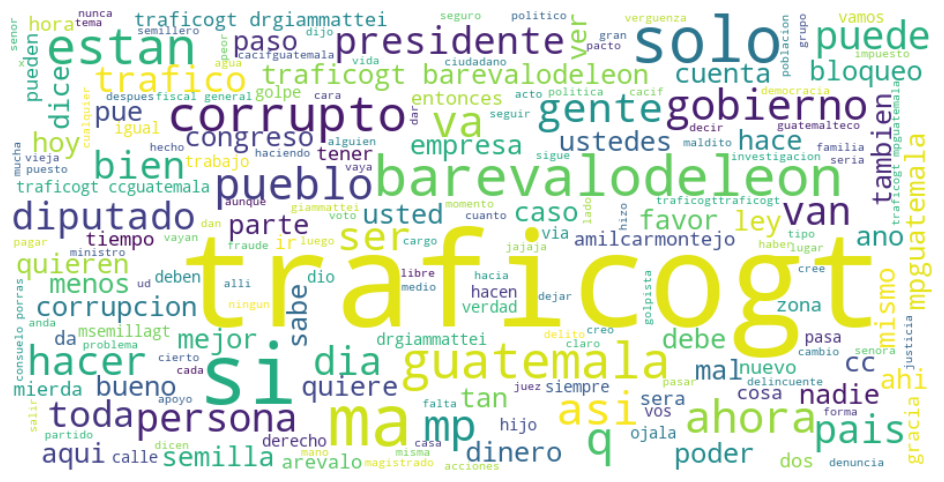

In [25]:
get_word_cloud(df_trafico, 'processed_text')

### Preguntas Interesantes
#### Bernardo Arévalo
- ¿Quiénes son las cuentas que más se mencionan junto a la del presidente?
- ¿Cuál es el hashtag más frecuente?

#### TraficoGT
- ¿Cuáles son los hashtags más frecuentes?
- ¿Cuál es la palabra más frecuente que parece representar la causa del tráfico?
- ¿Cuáles son las cuentas que más se mencionan?

## 5. Análisis de Topología

#### 5.1 Visualización de grafos

In [26]:
def visualize_graph(G, title, top_n=25):
    # Calculate degree centrality to filter the top N nodes
    degree_centrality = nx.degree_centrality(G)

    # Sort nodes by degree centrality and keep only the top N
    top_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:top_n]
    subgraph = G.subgraph(top_nodes)  # Create a subgraph with only the top N nodes

    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(subgraph, k=0.1)

    # Draw nodes with size and color based on degree centrality
    node_size = [degree_centrality[node] * 1000 for node in subgraph]  # Scale node size
    node_color = [degree_centrality[node] for node in subgraph]  # Color based on centrality
    nx.draw_networkx_nodes(subgraph, pos, node_size=node_size, node_color=node_color, cmap=plt.cm.viridis, alpha=0.9)

    # Draw edges
    nx.draw_networkx_edges(subgraph, pos, arrowstyle='->', arrowsize=10, edge_color='gray')

    # Draw labels for all the nodes
    degrees = dict(subgraph.degree())
    nx.draw_networkx_labels(subgraph, pos, labels={node: node for node, degree in degrees.items() if degree > 5}, font_size=10)

    # Add a color bar for degree centrality
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(degree_centrality.values()), vmax=max(degree_centrality.values())))
    sm.set_array([])
    plt.colorbar(sm, label='Degree Centrality')

    plt.title(f"{title} - Top {top_n} Nodes by Degree Centrality")
    plt.show()


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

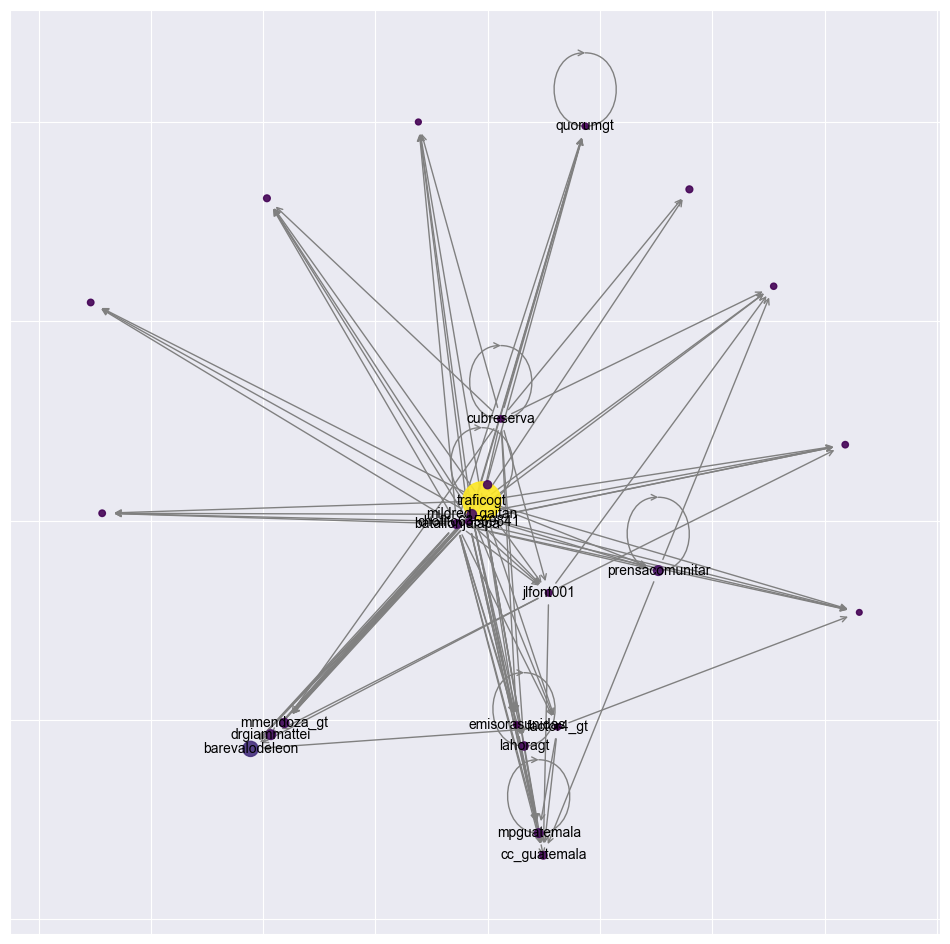

In [27]:
visualize_graph(G_trafico, 'Grafo de interacciones de TraficoGT')

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

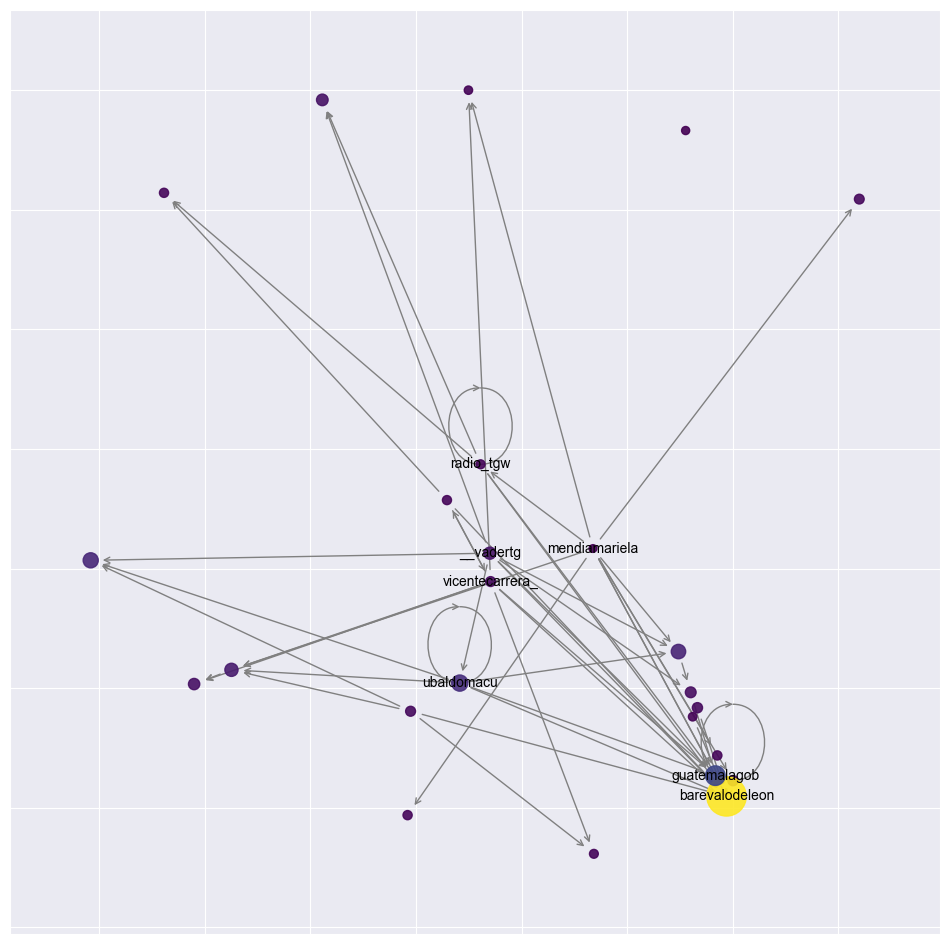

In [28]:
visualize_graph(G_arevalo, 'Grafo de interacciones de Bernardo Arévalo')

#### 5.2 Métricas

In [29]:
def calculate_network_metrics(G):
    # Densidad de la red
    density = nx.density(G)

    # Convert to undirected graph for diameter calculation
    if nx.is_connected(G.to_undirected()):
        diameter = nx.diameter(G.to_undirected())
    else:
        diameter = float('inf')  # Si la red no está conectada, el diámetro es infinito

    # Coeficiente de agrupamiento
    clustering_coefficient = nx.average_clustering(G)

    return {
        'density': density,
        'diameter': diameter,
        'clustering_coefficient': clustering_coefficient
    }

In [30]:
metrics_trafico = calculate_network_metrics(G_trafico)

In [31]:
metrics_arevalo = calculate_network_metrics(G_arevalo)

In [32]:
print("Métricas de la red de TraficoGT:")
print(f"Densidad: {metrics_trafico['density']}")
print(f"Diámetro: {metrics_trafico['diameter']}")
print(f"Coeficiente de agrupamiento: {metrics_trafico['clustering_coefficient']}")

Métricas de la red de TraficoGT:
Densidad: 0.0010056077011295118
Diámetro: 4
Coeficiente de agrupamiento: 0.17672844963233308


In [33]:
print("Métricas de la red de Bernardo Arévalo:")
print(f"Densidad: {metrics_arevalo['density']}")
print(f"Diámetro: {metrics_arevalo['diameter']}")
print(f"Coeficiente de agrupamiento: {metrics_arevalo['clustering_coefficient']}")

Métricas de la red de Bernardo Arévalo:
Densidad: 0.0012755094246539962
Diámetro: 6
Coeficiente de agrupamiento: 0.1917410292546775
